In [1]:
import os

import pandas as pd
import numpy as np

from dotenv import load_dotenv
from nixtlats import TimeGPT
from usageUtils import getUsageData
from IPython.display import Markdown

load_dotenv()

True

In [2]:
timegpt = TimeGPT(token=os.getenv("TIMEGPT_TOKEN"))

timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [3]:
# Get current API token usage data

getUsageData()

Current usage data:

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  158   ||   TOKENS:  549202   ||   SPENT:  910.12          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [4]:
# DATA PREP: Create dataframe from csv file, convert 'TimePeriod' column to timezone-naive datetime, remove uneccessary columns, save to csv file, create new dataframe from csv file, return new dataframe

def dataPrep(dfName, csvName, timeCol, dropCols, csvNameUpdate):
    dfName = pd.read_csv(csvName)
    dfName[timeCol] = pd.to_datetime(dfName[timeCol]).dt.tz_localize(None)
    dfName = dfName.drop(columns=dropCols)
    dfName.to_csv(csvNameUpdate, index=False)
    dfName = pd.read_csv(csvNameUpdate)
    return dfName

In [5]:
# Run dataPrep function on sample data

df = dataPrep(
    dfName="df",
    csvName="../data/raw/billing2_raw.csv",
    timeCol="TimePeriod",
    dropCols=["Tenant"],
    csvNameUpdate="../data/clean/billing2_clean.csv"
)

display(df.head())

,TimePeriod,ProratedQuantity
0,2023-09-14,93218.526165
1,2023-09-15,104783.771445
2,2023-09-16,97060.344313
3,2023-09-17,96852.455640
4,2023-09-18,110037.811158


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2023-10-16,0,103994.822666,123016.968750,142039.114834
1,2023-10-17,0,110264.611729,129286.757812,148308.903896
2,2023-10-18,0,112312.760166,131334.906250,150357.052334
3,2023-10-19,0,107988.775791,127010.921875,146033.067959
4,2023-10-20,0,107433.963291,126456.109375,145478.255459
...,...,...,...,...,...
142,2024-03-06,0,49269.064854,68291.210938,87313.357021
143,2024-03-07,0,49232.057041,68254.203125,87276.349209
144,2024-03-08,0,48854.353916,67876.500000,86898.646084
145,2024-03-09,0,48782.830479,67804.976562,86827.122646


### Detected Anomalies (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
8,2023-10-24,1,104763.033604,123785.179688,142807.325771
9,2023-10-25,1,107263.025791,126285.171875,145307.317959
10,2023-10-26,1,102314.541416,121336.687500,140358.833584
12,2023-10-28,1,100271.603916,119293.750000,138315.896084
13,2023-10-29,1,100967.260166,119989.406250,139011.552334
18,2023-11-03,1,83249.111729,102271.257812,121293.403896


### Results Comparison Plot (Default 99% Prediction Interval Level)

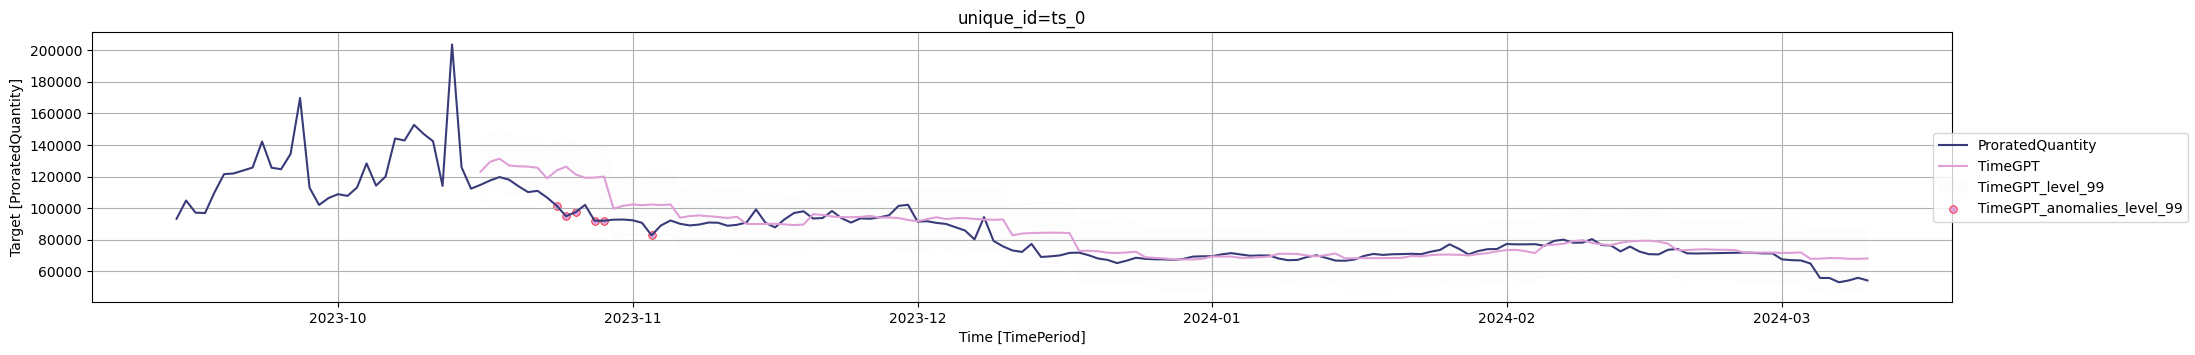

In [8]:
# Run anomaly detection model, plot results compared with original data (default prediction interval level is 99)

dfAnoms = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D"
)

dfAnomsOnly = dfAnoms[dfAnoms["anomaly"] == 1]

plotAnoms = timegpt.plot(
    df, dfAnoms, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (Default 99% Prediction Interval Level)"),
    dfAnoms,
    Markdown("### Detected Anomalies (Default 99% Prediction Interval Level)"),
    dfAnomsOnly,
    Markdown("### Results Comparison Plot (Default 99% Prediction Interval Level)"),
    plotAnoms,
)

In [9]:
getUsageData(update=True)

Usage data successfully updated with: 4 . . . . .
<<  1 call  ••  914 tokens  ••  2.57 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  160   ||   TOKENS:  551030   ||   SPENT:  915.26          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [ ]:
# Get historical prediction intervals to test against detected anomalies

dfFcst = timegpt.forecast(
    df, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, level=[99, 90, 99.99],
)

dfFcst = dfFcst.merge(df)

for lv in [99, 90, 99.99]:
    dfFcst[f"anomaly_{lv}"] = (
        dfFcst["ProratedQuantity"] > dfFcst[f"TimeGPT-hi-{lv}"]
    ) | (
        dfFcst["ProratedQuantity"] < dfFcst[f"TimeGPT-lo-{lv}"]
    )

    dfFcst[f"anomaly_{lv}"] = dfFcst[f"anomaly_{lv}"].astype(np.int64)

In [ ]:
# Test detected anomalies against historical prediction intervals defalut level 99

pd.testing.assert_series_equal(
    dfFcst["anomaly_99"],
    dfAnoms.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

In [ ]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 90 should identify more anomalies)

dfAnoms90 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=90
)

dfAnomsOnly90 = dfAnoms[dfAnoms["anomaly"] == 1]

plotAnoms90 = timegpt.plot(
    df, dfAnoms90, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (90% Prediction Interval Level)"),
    dfAnoms90,
    Markdown("### Detected Anomalies (90% Prediction Interval Level)"),
    dfAnomsOnly90,
    Markdown("### Results Comparison Plot (90% Prediction Interval Level)"),
    plotAnoms90,
)

In [ ]:
# Test detected anomalies against historical prediction interval level 90

pd.testing.assert_series_equal(
    dfFcst["anomaly_90"],
    dfAnoms90.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

In [ ]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

dfAnoms99_99 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=99.99,
)

dfAnomsOnly99_99 = dfAnoms99_99[dfAnoms99_99["anomaly"] == 1]

plotAnoms99_99 = timegpt.plot(
    df, dfAnoms99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level)"),
    dfAnoms99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level)"),
    dfAnomsOnly99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level)"),
    plotAnoms99_99,
)

In [ ]:
# Test detected anomalies against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    dfFcst["anomaly_99.99"],
    dfAnoms99_99.merge(df)["anomaly"],
    check_index=False,
    check_names=False,
)

In [ ]:
# Get historical prediction intervals to test against detected anomalies with exogenous variables

dfFcstX = timegpt.forecast(
    df, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, date_features=True, level=[99, 90, 99.99],
)

dfFcstX = dfFcstX.merge(df)

for lv in [99, 90, 99.99]:
    dfFcstX[f"anomaly_{lv}"] = (
        dfFcstX["ProratedQuantity"] > dfFcstX[f"TimeGPT-hi-{lv}"]
    ) | (
        dfFcstX["ProratedQuantity"] < dfFcstX[f"TimeGPT-lo-{lv}"]
    )

    dfFcstX[f"anomaly_{lv}"] = dfFcstX[f"anomaly_{lv}"].astype(np.int64)

In [ ]:
# Run anomaly detection model with exogeneous variables, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

dfAnomsX99_99 = timegpt.detect_anomalies(
    df, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", date_features=True, level=99.99,
)

dfAnomsOnlyX99_99 = dfAnomsX99_99[dfAnomsX99_99["anomaly"] == 1]

plotAnomsX99_99 = timegpt.plot(
    df, dfAnomsX99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level with Exogeneous Variables)"),
    dfAnomsX99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level with Exogeneous Variables)"),
    dfAnomsOnlyX99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level with Exogeneous Variables)"),
    plotAnomsX99_99,
)

In [ ]:
# Test detected anomalies with exogeneous variables against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    dfFcstX["TimeGPT-lo-99.99"],
    dfAnomsX99_99.merge(df)["TimeGPT-lo-99.99"],
    check_index=False,
    check_names=False,
    rtol=1,
    atol=1,
)

In [ ]:
# Get updated API token usage data

getUsageData(update=True)